### RRP Usage Tracker

- Plot ON RRP take-up vs fed funds & T-bill yields; flag “arbitrage windows.”
- Data: FRED (e.g., RRPONTSYAWARD, RRPONTSYD, DTB4WK).
- Output: chart + alert when RRP rate > bill yield(4WKR).

##### Why investors compare RRP rate to 4 WK yield and not 3M/6M yield **?**

1. Maturity Proximity
    - RRP = overnight (1 day).
    - US1M = ~30 days → closest available market instrument to “cash” on the yield curve.
    - US3M / US6M → reflect more than just liquidity; they embed policy path expectations (e.g., expected Fed hikes/cuts in 3–6 months).
    👉 So 3M/6M are forward-looking rates, not direct competitors to an overnight facility.<br><br>

2. Investor Substitution Logic
    - Money Market Funds (MMFs) choose between:
        - Parking cash in RRP (overnight, safe), or
        - Buying very short bills (1M or 4W).

They rarely think: “Do I buy a 6M bill instead of RRP?” because:

    - Duration risk grows.
    - NAV fluctuations matter.

Cash needs are shorter.
👉 So RRP vs US1M/4W is the true substitution margin.

In [323]:
import pandas as pd
from pandas_datareader import data as web
import plotly.graph_objects as go
from datetime import date

START = "2015-01-01"
END = None

series = ['RRPONTSYAWARD', 'DTB4WK','RRPONTSYD']  #  1M  bills, ON RRP
df = pd.concat({s: web.DataReader(s, 'fred') for s in series}, axis=1).dropna()
df.columns = ["ON_RRP_RATE", "4WKR", "RRP_LEVEL_USD_BN"]

df.dropna(how='all', inplace=True)
df = df.ffill()

🔹 **Nature of the Two Rates**

- ON RRP (Overnight Reverse Repo Rate)
    - Risk-free floor rate, set by the Fed.
    - Any eligible counterparty can lend cash to the Fed overnight, fully collateralized by Treasuries.
    - Acts as a “benchmark” for where very short-term money markets clear.<br><br>

- 1-Month Treasury Yield (US1M)
    - Market-determined rate on a short-term government security.
    - Reflects supply/demand for T-bills, expectations of policy, and liquidity conditions.
    - Considered a very close substitute to holding cash overnight in RRP, just slightly longer in maturity.

In [338]:
# If RRP > 1M bill yield, money funds prefer RRP -> flag
BASIS_THRESHOLD = 5
df['spread_bp'] = (df['ON_RRP_RATE'] - df['4WKR']) * 100  # basis points
df['ArbitrageText'] = df['spread_bp'].apply(lambda s: f"Arb Window Open (+{s:.1f}bps)" if s > BASIS_THRESHOLD else f"Arb Window Closed ({s:.1f}bps)")
df['spread_bp_roll21'] = df['spread_bp'].rolling(21).mean().round(2) #~1M average
df.tail(1)

,ON_RRP_RATE,4WKR,RRP_LEVEL_USD_BN,spread_bp,ArbitrageText,spread_bp_roll21
DATE,,,,,,
2025-08-27,4.25,4.24,34.744,1.0,Arb Window Closed (1.0bps),-2.62


In [327]:
spread_bp_stats = df['spread_bp'].to_frame().describe().T
spread_bp_stats

,count,mean,std,min,25%,50%,75%,max
spread_bp,1203.0,3.182045,18.975445,-73.0,-2.0,1.0,4.0,151.0


In [329]:
s = df['spread_bp']
q95 = s.quantile(0.95)
top_5_percent = s[s > q95]
top_5_percent.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
spread_bp,61.0,61.213115,27.051257,35.0,42.0,55.0,67.0,151.0


#### How to Interpret the Spread

- Positive Spread (RRP > 4W Bill) (MMFs prefer RRP → excess liquidity in system)
     - Indicates that money-market funds and other cash investors may find it more profitable to park funds at the Fed via RRP than invest in short-term T-bills. Suggests excess liquidity in the system, where demand for safe, short-term instruments is being absorbed by the RRP facility.
     -  There are not enough short-term instruments. Yields on Money-Market instruments are lower than RRP Rate basically.
     -  Demand high for MM instruments -> Prices high -> yields lower. 
     - Implies the RRP facility is serving as a rate floor for money-market investments.
- Negative Spread (RRP < 4W Bill) (rare in normal conditions)
    - RRP < US1M → Bills more attractive → could reflect reduced liquidity or heavy bill issuance
    - (Uncommon) Bills preferred—might indicate RRP facility congestion or tightness.

In [281]:
df.loc[y2_maxidx]

ON_RRP_RATE                                 4.8
US1M                                       3.36
RRP_LEVEL_USD_BN                       2290.023
spread_bp                                 144.0
spread_bp_roll21                          53.81
ArbitrageText       Arb Window Open (+144.0bps)
Name: 2023-04-21 00:00:00, dtype: object

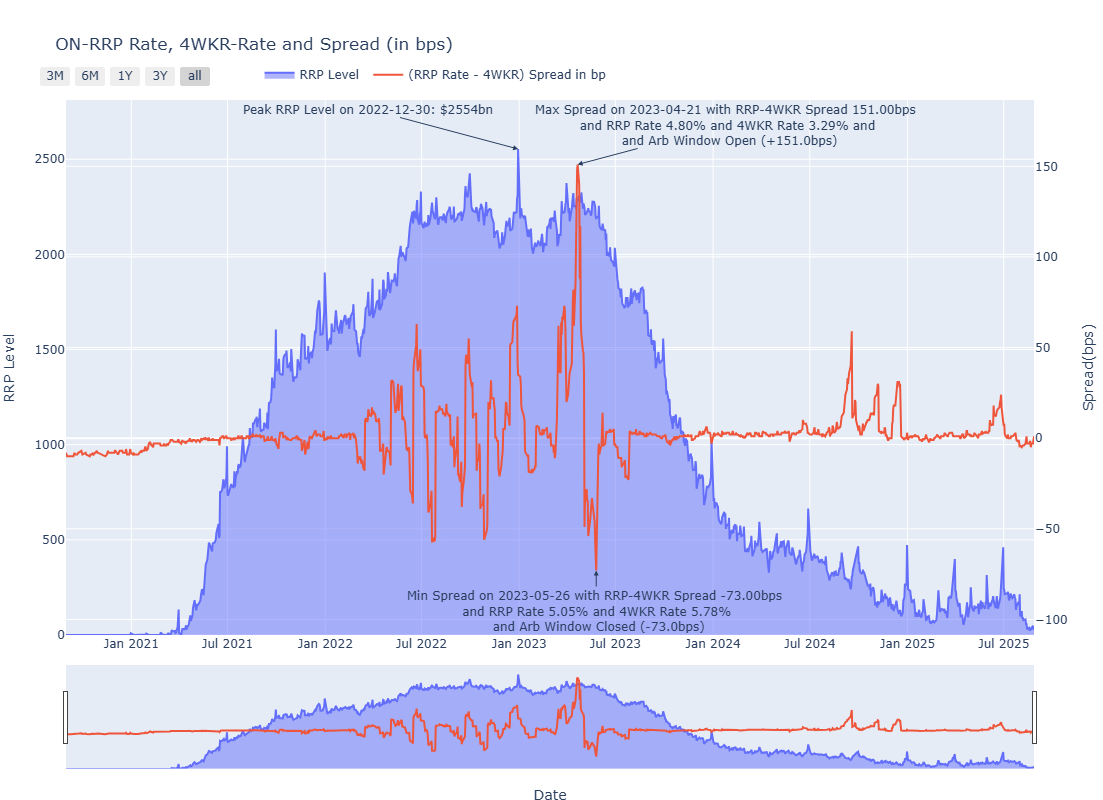

In [358]:
fig = go.Figure()

#fig.add_trace(go.Scatter(x=df.index, y=df['4WKR'], name = '1M-T Bill ', mode="lines"))
#fig.add_trace(go.Scatter(x=df.index, y=df['ON_RRP_RATE'], name = 'RRP Rate ', mode="lines"))

fig.add_trace(go.Scatter(x=df.index, y=df['RRP_LEVEL_USD_BN'], fill='tozeroy', name = 'RRP Level ', mode="lines"))
fig.add_trace(go.Scatter(x=df.index, y=df['spread_bp'], name = '(RRP Rate - 4WKR) Spread in bp', mode="lines", yaxis="y2"))
#fig.add_trace(go.Scatter(x=df.index, y=df['spread_bp_roll21'], name = 'Spread Rolling average 21 days', mode="lines", yaxis="y2"))

fig.update_layout(
    title="ON-RRP Rate, 4WKR-Rate and Spread (in bps)",
    hovermode="x unified",
    legend=dict(xanchor="left", yanchor="bottom", orientation="h", x=0.2, y=1.02),
    margin=dict(l=40,r=40,t=100,b=10),
    xaxis=dict(title="Date "),
    yaxis=dict(title="RRP Level"),
    yaxis2=dict(title=" Spread(bps)", side="right", overlaying="y"),
    height=800
)

# Add quick zoom buttons
fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=3, label='3M', step="month", stepmode="backward"),
            dict(count=6, label='6M', step="month", stepmode="backward"),
            dict(count=1, label='1Y', step="year", stepmode="backward"),
            dict(count=3, label='3Y', step="year", stepmode="backward"),
            dict(step="all")
        ])
    ),
    rangeslider=dict(visible=True)
)

y_maxidx = df["RRP_LEVEL_USD_BN"].idxmax()
y_max = df.loc[y_maxidx].RRP_LEVEL_USD_BN

y2_maxidx = df['spread_bp'].idxmax()
y2_max = df.loc[y2_maxidx, 'spread_bp']
y2_max_rrprate = df.loc[y2_maxidx, "ON_RRP_RATE"]
y2_max_4WKR = df.loc[y2_maxidx, "4WKR"]

y2_minidx = df['spread_bp'].idxmin()
y2_min = df.loc[y2_minidx, 'spread_bp']
y2_min_rrprate = df.loc[y2_minidx, "ON_RRP_RATE"]
y2_min_4WKR = df.loc[y2_minidx, "4WKR"]

fig.update_layout(annotations=list([
    dict(x=y2_minidx, yref='y2', y=y2_min, text= f"Min Spread on {y2_minidx.strftime('%Y-%m-%d')} with RRP-4WKR Spread {y2_min:.2f}bps <br> and RRP Rate {y2_min_rrprate:.2f}% and 4WKR Rate {y2_min_4WKR:.2f}% <br> and {df.loc[y2_minidx,'ArbitrageText']}" , showarrow=True, arrowhead=2, ax=0, ay=40),
    dict(x=y_maxidx, yref='y', y=y_max, text= f"Peak RRP Level on {y_maxidx.strftime('%Y-%m-%d')}: ${y_max:.0f}bn", showarrow=True, arrowhead=2, ax=-150, ay=-40), 
    dict(x=y2_maxidx, yref='y2', y=y2_max, text= f"Max Spread on {y2_maxidx.strftime('%Y-%m-%d')} with RRP-4WKR Spread {y2_max:.2f}bps <br> and RRP Rate {y2_max_rrprate:.2f}% and 4WKR Rate {y2_max_4WKR:.2f}% and <br> and {df.loc[y2_maxidx,'ArbitrageText']}", showarrow=True, arrowhead=2, ax=150, ay=-40)
])

)

fig.show()

'A key period when market participants, primarily money market funds, used the arbitrage window between the Overnight Reverse Repurchase Agreement (ON RRP) rate and the 4-week Treasury bill rate was in 2022 and 2023.

The arbitrage became attractive due to a combination of factors related to the Federal Reserve's monetary policy and the U.S. Treasury's borrowing needs.

**The Arbitrage Window**<br>
During this period of the Fed's quantitative tightening (QT) and rapid interest rate hikes, the ON RRP rate was consistently higher than the yield on the 4-week Treasury bill. This created a clear, risk-free arbitrage opportunity. The ON RRP rate is the fixed, floor rate the Fed pays on an overnight basis. The 4-week Treasury bill is a short-term government debt security with a variable yield that is **sensitive to market supply and demand**.

Because the ON RRP rate was guaranteed and often higher, money market funds could profit by selling their lower-yielding 4-week Treasury bills and instead parking their cash in the Fed's ON RRP facility to earn a better, risk-free return. This behavior caused the ON RRP facility's usage to surge to unprecedented levels, at one point exceeding $2.5 trillion.

**Why It Happened<br>
This specific arbitrage window was a direct result of the interplay between monetary and fiscal policy:**

**Fed's Aggressive Rate Hikes**: The Federal Reserve was rapidly raising interest rates to combat inflation. It kept the ON RRP rate at the bottom of its target range, but still raised it with each hike, making it a very attractive "parking lot" for cash.

**Treasury's Issuance**: At the same time, the U.S. Treasury was issuing new debt, particularly longer-dated securities, to fund the government. The supply of short-term Treasury bills was not keeping up with the demand for safe, short-term assets, which put downward pressure on their yields.

The resulting gap between the higher, stable ON RRP rate and the lower, market-driven T-bill rate made the arbitrage profitable and led to the massive increase in ON RRP usage. The arbitrage activity declined significantly in late 2023 and 2024 as the Treasury increased its issuance of short-term bills to replenish its cash reserves, causing T-bill yields to rise and close the arbitrage window.

In [283]:
df.loc[y2_minidx]

ON_RRP_RATE                                 5.05
US1M                                        6.02
RRP_LEVEL_USD_BN                        2189.681
spread_bp                                  -97.0
spread_bp_roll21                          -45.52
ArbitrageText       Arb Window Closed (-97.0bps)
Name: 2023-05-26 00:00:00, dtype: object

In summary, when liquidity tightens, Treasury bills (T-bills) often trade at yields higher than the Fed's overnight reverse repo (RRP) rate due to increased demand for cash and a shortage of other short-term assets. On other hand, when there is enough cash supply, ample liquidity in the market, supply of cash exceeds the demand of cash, t-bill yields are lower. In such times if RRP offers attractive yields cash is moved to Fed's safer compensating investors for any incremental risks or market frictions. 